# 전이학습

## 데이터 로드

In [2]:
# 데이터 경로 지정
train_dir = './data/dogs_vs_cats_small/train'
val_dir = './data/dogs_vs_cats_small/validation'
test_dir ='./data/dogs_vs_cats_small/test'

# 라벨링
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 픽셀값 변환
train_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)
val_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_gen.flow_from_directory(
    train_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)

val_generator = val_gen.flow_from_directory(
    val_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)

test_generator = test_gen.flow_from_directory(
    test_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)

# 라벨링 결과 확인
print(train_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [ ]:
train_generator = train_gen.flow_from_directory(
    train_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)

val_generator = val_gen.flow_from_directory(
    val_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)

test_generator = test_gen.flow_from_directory(
    test_dir, # train 이미지 경로    
    target_size = (150,150), # 변환할 이미지의 크기
    batch_size = 100, # 한번에 변환할 이미지 갯수
    class_mode = 'binary' # 라벨링 진행, categorical : 다중분류
    # 폴더별로 라벨링을 진행 cats(0) , dogs(1)
)



## 전이학습 : 누군가 만들어놓은 모델 가져오기

In [7]:
from tensorflow.keras.applications import VGG16

# 특성 추출기
conv_base = VGG16(
    weights = 'imagenet', # imagenet에서 사용한 가중치 가져오기
    include_top = False, # 분류기를 사용할것인가? 
    input_shape = (150,150,3)
)

58892288/58889256 [==============================] - 12s 0us/step


In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 동결 : 가중치가 갱신되는 것을 막는 것

In [10]:
# 학습 가능한 가중치의 갯수 확인
len(conv_base.trainable_weights)

26

In [19]:
# VGG16 전체 층에대해 동결
conv_base.trainable = False

In [12]:
# 학습 가능한 가중치의 갯수 확인
len(conv_base.trainable_weights)

0

### 모델 정의

In [13]:
# 동결된 conv를 사용해서 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model2 = Sequential()
# 전이학습할 모델의 특성추출부 사용하기
model2.add(conv_base) 
model2.add(Flatten())
model2.add(Dense(units = 256, activation = 'relu'))
# 출력층
model2.add(Dense(units = 1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
               )

### 모델 학습

In [16]:
model2.fit_generator(
    generator = train_generator,
    epochs = 20,
    validation_data = val_generator
)

Epoch 1/20


2023-02-14 03:13:12.991386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.8387 - accuracy: 0.7185

2023-02-14 03:13:21.177060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 12s 605ms/step - loss: 0.8387 - accuracy: 0.7185 - val_loss: 0.3228 - val_accuracy: 0.8580
Epoch 2/20
20/20 [==============================] - 12s 585ms/step - loss: 0.2610 - accuracy: 0.8875 - val_loss: 0.2546 - val_accuracy: 0.8960
Epoch 3/20
20/20 [==============================] - 12s 581ms/step - loss: 0.1907 - accuracy: 0.9255 - val_loss: 0.2418 - val_accuracy: 0.9040
Epoch 4/20
20/20 [==============================] - 12s 584ms/step - loss: 0.1429 - accuracy: 0.9525 - val_loss: 0.2388 - val_accuracy: 0.9030
Epoch 5/20
20/20 [==============================] - 12s 600ms/step - loss: 0.1151 - accuracy: 0.9615 - val_loss: 0.2431 - val_accuracy: 0.9020
Epoch 6/20
20/20 [==============================] - 12s 584ms/step - loss: 0.0945 - accuracy: 0.9730 - val_loss: 0.2377 - val_accuracy: 0.9060
Epoch 7/20
20/20 [==============================] - 12s 580ms/step - loss: 0.0719 - accuracy: 0.9835 - val_loss: 0.2437 - val_accuracy: 0.9060
Epoch 8/20

## 미세조정

In [20]:
from tensorflow.keras.applications import VGG16

# 특성 추출기
conv_base = VGG16(
    weights = 'imagenet', # imagenet에서 사용한 가중치 가져오기
    include_top = False, # 분류기를 사용할것인가? 
    input_shape = (150,150,3)
)

In [21]:
# 학습 가능한 가중치의 갯수 확인
len(conv_base.trainable_weights)

26

#### 미세조정1

In [26]:
conv_base.trainable=True

fine_tune_at=10
for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable=False

In [25]:
# 학습 가능한 가중치의 갯수 확인
len(conv_base.trainable_weights)

12

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 미세조정2

In [28]:
# block5_conv1 ~ 3 층을 학습시켜보자

# block5_conv1 층부터 하위의 층의 동결을 해제
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

In [29]:
len(model2.trainable_weights)

4

In [30]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
               )

In [32]:
model2.fit_generator(
    generator = train_generator,
    epochs = 20,
    validation_data = val_generator
)

/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


2023-02-14 03:28:47.217522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9385

2023-02-14 03:28:55.342304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 12s 595ms/step - loss: 0.1489 - accuracy: 0.9385 - val_loss: 0.4626 - val_accuracy: 0.8570
Epoch 2/20
20/20 [==============================] - 11s 578ms/step - loss: 0.0228 - accuracy: 0.9975 - val_loss: 0.3419 - val_accuracy: 0.8980
Epoch 3/20
20/20 [==============================] - 11s 576ms/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 0.3329 - val_accuracy: 0.9070
Epoch 4/20
20/20 [==============================] - 11s 574ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9050
Epoch 5/20
20/20 [==============================] - 12s 580ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.9080
Epoch 6/20
20/20 [==============================] - 12s 591ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3396 - val_accuracy: 0.9100
Epoch 7/20
20/20 [==============================] - 12s 597ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3455 - val_accuracy: 0.9060
Epoch 8/20

# [실습] 패션데이터셋을 이용한 이미지 분류

- 패션 데이터셋  
10가지의 패션 이미지 데이터로 구성  
60000개의 데이터  
이미지 크기 : 28 x 28

- Xception 모델을 전이학습

## 데이터 로드

In [33]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [34]:
# 훈련데이터 1000개, 테스트데이터 300개만 사용
X_train = X_train[:1000, :]
y_train = y_train[:1000]
X_test = X_test[:300, :]
y_test = y_test[:300]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 28, 28), (1000,), (300, 28, 28), (300,))

In [35]:
# y의 라벨 확인
import pandas as pd

print(pd.Series(y_train).unique())
print(pd.Series(y_test).unique())

[9 0 3 2 7 5 1 6 4 8]
[9 2 1 6 4 5 7 3 8 0]


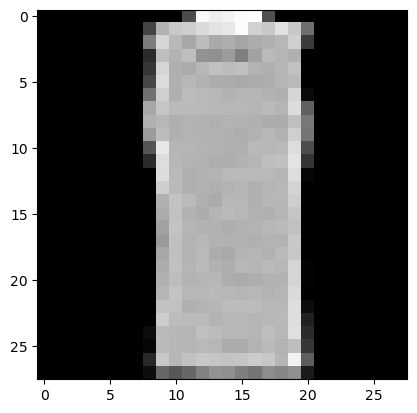

In [36]:
# 이미지 확인
import matplotlib.pyplot as plt

plt.imshow(X_train[160], cmap="gray")

In [37]:
# y를 원핫 인코딩
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((1000, 10), (300, 10))

In [38]:
# 이미지를 (244, 244) 크기로 변환
from PIL import Image
import numpy as np

train_resize_list = []
for i in range(len(X_train)) :
  train_resize_img = Image.fromarray(X_train[i]).resize((244, 244))
  train_resize_list.append(np.array(train_resize_img))

test_resize_list = []
for i in range(len(X_test)) :
  test_resize_img = Image.fromarray(X_test[i]).resize((244, 244))
  test_resize_list.append(np.array(test_resize_img))

In [39]:
X_train_resized = np.array(train_resize_list)
X_test_resized = np.array(test_resize_list)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244), (300, 244, 244))

In [40]:
# 색상채널 차원 추가
X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], 244, 244, 1)
X_test_resized = X_test_resized.reshape(X_test_resized.shape[0], 244, 244, 1)

X_train_resized.shape, X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

## 모델 정의

In [41]:
# 신경망 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model1 = Sequential()

# CNN 층 설계 - 특성 추출기
# CNN 층의 최종 크기는 10x10보다 크거나 작거나
model1.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(244, 244, 1), activation="relu"))
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 다차원 데이터를 1차원을 변환
model1.add(Flatten())

# 분류기 모델 설계
model1.add(Dense(units=256, activation="relu"))
model1.add(Dense(units=64, activation="relu"))
model1.add(Dense(units=10, activation="softmax"))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 242, 242, 32)      320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 240, 240, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 118, 118, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 116, 116, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 430592)           

In [42]:
model1.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

## 모델 학습

In [43]:
h1 = model1.fit(X_train_resized, y_train_en, batch_size=20, epochs=10,
                validation_data=(X_test_resized, y_test_en))

Epoch 1/10


2023-02-14 03:43:11.678148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 34.6620 - accuracy: 0.5640

2023-02-14 03:43:28.598926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 20s 363ms/step - loss: 34.6620 - accuracy: 0.5640 - val_loss: 0.8938 - val_accuracy: 0.7300
Epoch 2/10
50/50 [==============================] - 18s 369ms/step - loss: 0.4568 - accuracy: 0.8630 - val_loss: 0.6557 - val_accuracy: 0.8100
Epoch 3/10
50/50 [==============================] - 18s 364ms/step - loss: 0.2006 - accuracy: 0.9340 - val_loss: 0.7450 - val_accuracy: 0.8100
Epoch 4/10
50/50 [==============================] - 18s 366ms/step - loss: 0.1066 - accuracy: 0.9680 - val_loss: 0.7368 - val_accuracy: 0.8100
Epoch 5/10
50/50 [==============================] - 18s 363ms/step - loss: 0.0657 - accuracy: 0.9810 - val_loss: 1.0258 - val_accuracy: 0.8067
Epoch 6/10
50/50 [==============================] - 18s 362ms/step - loss: 0.0479 - accuracy: 0.9840 - val_loss: 0.8355 - val_accuracy: 0.8267
Epoch 7/10
50/50 [==============================] - 18s 363ms/step - loss: 0.0200 - accuracy: 0.9930 - val_loss: 1.0706 - val_accuracy: 0.8167
Epoch 8/1

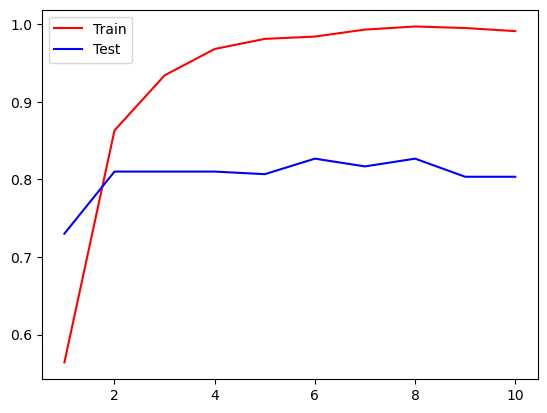

In [44]:
# 데이터 시각화
import matplotlib.pyplot as plt

acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]

e = range(1, len(acc) + 1)

plt.plot(e, acc, "r", label="Train")
plt.plot(e, val_acc, "b", label="Test")
plt.legend()